# Error Analysis

### Components
* What metadata is contained in each ontology?  How much is related to each entity?  Create dict of cui -> metadata tags.  
  * Has definition
  * Number of aliases
  * Species (ncbigene)
  * Type(s)
  * Semantic group (UMLS)
* How common are data in each dataset?  Get dictionary mapping each entity to appropriate statistics
  * Has alias match
  * Abbreviation?
  * Entity in training set
  * Exact string match in train set
  * Matches alias of different entity
  * Type (provided by dataset)
  * Ontology-listed type (if different)
  * Species (gene entities)
* Are there common errors made by all models?  Are there certain examples that only one model got right?
  
### Ontology processing
Make dataframe with following columns:
* CUI
* Type(s)
* Definition
* All aliases (besides name)
* Species (ncbigene)
* Semantic group (umls)

In [3]:
%load_ext autoreload
%autoreload 2

import pickle
import ujson
import sys
import os
import scipy

import pandas as pd
import numpy as np

from tqdm import tqdm
from collections import defaultdict
from matplotlib import pyplot as plt

from bigbio.dataloader import BigBioConfigHelpers
from datasets import load_dataset
conhelps = BigBioConfigHelpers()


sys.path.append('..')
from umls_utils import UmlsMappings
from bigbio_utils import CUIS_TO_REMAP, CUIS_TO_EXCLUDE, DATASET_NAMES, VALIDATION_DOCUMENT_IDS#, MODELS
from bigbio_utils import dataset_to_documents, dataset_to_df, resolve_abbreviation, dataset_to_pretty_name#, model_to_pretty_name

model_to_pretty_name = {
    "sapbert": "SapBERT",
    "metamap": "MetaMap",
    "krissbert": "KRISSBERT",
    "scispacy": "SciSpacy",
    "medlinker": "MedLinker",
    "arboel_biencoder": "ClusterEL",
    "arboel_crossencoder": "ArboEL",
    "biobart": "BioBART",
    "biogenel": "BioGenEL",
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [5]:
name = 'ncbi_disease'
data = conhelps.for_config_name(f'{name}_bigbio_kb').load_dataset(from_hub=False)
print(type(data))

Found cached dataset ncbi_disease (/nethome/dkartchner3/.cache/huggingface/datasets/ncbi_disease/ncbi_disease_bigbio_kb/1.0.0/e6b217666a5647d5abc614785b2caad62f1d72a94d1631b86c0f615b75dcc865)


  0%|          | 0/3 [00:00<?, ?it/s]

<class 'datasets.dataset_dict.DatasetDict'>


In [2]:
umls_dir="/mitchell/entity-linking/2017AA/META/"
umls = UmlsMappings(
    umls_dir=umls_dir, debug=False, force_reprocess=False, 
)

lowercase=False

# Full UMLS Canonical Names
print("Getting Names")
umls_to_name = umls.get_canonical_name(ontologies_to_include="all",
    use_umls_curies=True,
    lowercase=lowercase,)

Loading cached UMLS data from /mitchell/entity-linking/2017AA/META/.cached_df.feather
Getting Names


/nvme/home/dkartchner3/research/entity_linking/el-robustness-comparison/notebooks/../umls_utils.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["identifier"] = df["cui"]


In [3]:
all_umls_df = umls.umls.query('lang == "ENG"').groupby('cui').agg({'alias': lambda x: list(set(x)), 'tui':'first', 'group': 'first', 'def':'first'}).reset_index()
all_umls_df['name'] = all_umls_df.cui.map(umls_to_name)
# all_umls_df['alias'] = all_umls_df[['name','alias']].apply(lambda x: list(set(x[1]) - set([x[0]])) , axis=1)
all_umls_df['cui'] = all_umls_df['cui'].map(lambda x: 'UMLS:' + x)
all_umls_df['has_definition'] = all_umls_df['def'].map(lambda x: x is not None)
all_umls_df['num_aliases'] = all_umls_df['alias'].map(lambda x: len(x))
for col in ['tui','group']:
    all_umls_df[col] = all_umls_df[col].map(lambda x: list(x))
all_umls_df.head()


,cui,alias,tui,group,def,name,has_definition,num_aliases
0,UMLS:C0000005,"[(131)I-Macroaggregated Albumin, (131)I-MAA]","[T116, T121, T130]",[CHEM],None,(131)I-Macroaggregated Albumin,False,2
1,UMLS:C0000039,"[Dipalmitoylphosphatidylcholine, 1,2-Dipalmito...","[T109, T121]",[CHEM],Synthetic phospholipid used in liposomes and l...,"1,2-Dipalmitoylphosphatidylcholine",True,16
2,UMLS:C0000052,"[1,4-alpha-Glucan Branching Enzyme [Chemical/I...","[T116, T126]",[CHEM],"In glycogen or amylopectin synthesis, the enzy...","1,4-alpha-Glucan Branching Enzyme",True,23
3,UMLS:C0000074,"[1 Alkyl 2 Acylphosphatidates, 1-Alkyl-2-Acylp...",[T109],[CHEM],None,1-Alkyl-2-Acylphosphatidates,False,2
4,UMLS:C0000084,"[gamma-Carboxyglutamic Acid, 1-Carboxyglutamic...","[T116, T123]",[CHEM],"Found in various tissues, particularly in four...",1-Carboxyglutamic Acid,True,8


In [4]:
with open('../data/metadata_dicts/medmentions_full_ontology.json', 'w') as f:
    f.write(ujson.dumps(all_umls_df.set_index('cui').to_dict(orient='index')))


## ST21PV

In [5]:
st21pv_types = ujson.load(open('../data/st21pv_subtypes.json'))
st21pv_vocabs = ujson.load(open('../data/st21pv_vocabs.json'))
print(st21pv_types)
print(st21pv_vocabs)
st21pv_types_set = set(st21pv_types)

umls_df = umls.umls.query('(lang == "ENG") & (sab in @st21pv_vocabs)')
umls_df = umls_df.loc[umls_df.tui.map(lambda x: any([y in st21pv_types_set for y in x])),:]
umls_df = umls_df.groupby('cui').agg({'alias': lambda x: list(set(x)), 'tui':'first', 'group': 'first', 'def':'first'}).reset_index()
umls_df['name'] = umls_df.cui.map(umls_to_name)
# umls_df['alias'] = umls_df[['name','alias']].apply(lambda x: list(set(x[1]) - set([x[0]])) , axis=1)
umls_df['cui'] = umls_df['cui'].map(lambda x: 'UMLS:' + x)
umls_df['has_definition'] = umls_df['def'].map(lambda x: x is not None)
umls_df['num_aliases'] = umls_df['alias'].map(lambda x: len(x))
for col in ['tui','group']:
    umls_df[col] = umls_df[col].map(lambda x: list(x))

umls_df.head()

['T005', 'T007', 'T017', 'T022', 'T031', 'T033', 'T037', 'T038', 'T058', 'T062', 'T074', 'T082', 'T091', 'T092', 'T097', 'T098', 'T103', 'T168', 'T170', 'T201', 'T204', 'T018', 'T021', 'T023', 'T024', 'T025', 'T026', 'T028', 'T190', 'T019', 'T020', 'T034', 'T184', 'T039', 'T040', 'T041', 'T042', 'T043', 'T044', 'T045', 'T046', 'T047', 'T048', 'T191', 'T049', 'T050', 'T059', 'T060', 'T061', 'T063', 'T203', 'T029', 'T030', 'T083', 'T085', 'T086', 'T087', 'T088', 'T093', 'T094', 'T095', 'T104', 'T109', 'T114', 'T116', 'T196', 'T197', 'T120', 'T121', 'T195', 'T122', 'T123', 'T125', 'T126', 'T127', 'T129', 'T192', 'T130', 'T131', 'T089', 'T185', 'T002', 'T004', 'T008', 'T010', 'T011', 'T012', 'T013', 'T014', 'T015', 'T016']
['MSH', 'CPT', 'FMA', 'GO', 'HGNC', 'HPO', 'ICD10', 'ICD10CM', 'ICD9CM', 'MDR', 'MTH', 'NCBI', 'NCI', 'NDDF', 'NDFRT', 'OMIM', 'RXNORM', 'SNOMEDCT_US']


,cui,alias,tui,group,def,name,has_definition,num_aliases
0,UMLS:C0000005,"[(131)I-Macroaggregated Albumin, (131)I-MAA]","[T116, T121, T130]",[CHEM],None,(131)I-Macroaggregated Albumin,False,2
1,UMLS:C0000039,"[Dipalmitoylphosphatidylcholine, 1,2-Dipalmito...","[T109, T121]",[CHEM],Synthetic phospholipid used in liposomes and l...,"1,2-Dipalmitoylphosphatidylcholine",True,16
2,UMLS:C0000052,"[1,4-alpha-Glucan Branching Enzyme [Chemical/I...","[T116, T126]",[CHEM],"In glycogen or amylopectin synthesis, the enzy...","1,4-alpha-Glucan Branching Enzyme",True,20
3,UMLS:C0000074,"[1 Alkyl 2 Acylphosphatidates, 1-Alkyl-2-Acylp...",[T109],[CHEM],None,1-Alkyl-2-Acylphosphatidates,False,2
4,UMLS:C0000084,"[gamma-Carboxyglutamic Acid, 1-Carboxyglutamic...","[T116, T123]",[CHEM],"Found in various tissues, particularly in four...",1-Carboxyglutamic Acid,True,8


In [6]:
with open('../data/metadata_dicts/medmentions_st21pv_ontology.json', 'w') as f:
    f.write(ujson.dumps(umls_df.set_index('cui').to_dict(orient='index')))

In [5]:
bc5cdr = umls.umls.query('(lang == "ENG") & (sab =="MSH")')
bc5cdr = bc5cdr.groupby('sdui').agg({'alias': lambda x: list(set(x)), 'tui':'first', 'group': 'first', 'def':'first', 'cui':'first'}).reset_index()
bc5cdr['name'] = bc5cdr.cui.map(umls_to_name)
bc5cdr.drop(['cui'], axis=1)
# bc5cdr['alias'] = bc5cdr[['name','alias']].apply(lambda x: list(set(x[1]) - set([x[0]])) , axis=1)
bc5cdr['cui'] = bc5cdr['sdui'].map(lambda x: 'MESH:' + x)
bc5cdr['has_definition'] = bc5cdr['def'].map(lambda x: x is not None)
bc5cdr['num_aliases'] = bc5cdr['alias'].map(lambda x: len(x))
for col in ['tui','group']:
    bc5cdr[col] = bc5cdr[col].map(lambda x: list(x))
bc5cdr.head()

with open('../data/metadata_dicts/bc5cdr_ontology.json', 'w') as f:
    f.write(ujson.dumps(bc5cdr.set_index('cui').to_dict(orient='index')))

In [19]:
bc5cdr.head()

,sdui,alias,tui,group,def,cui,name,has_definition,num_aliases
0,C000002,"[2-(hydroxymethyl)-N,N-dimethylpiperidinium be...","[T109, T121]",[CHEM],None,MESH:C000002,bevonium,False,8
1,C000006,"[insulin (swine), insulin (pork), Actrapid ins...","[T116, T121]",[CHEM],None,MESH:C000006,"insulin, neutral",False,8
2,C000009,[N(4)-(2-acetamido-2-deoxyglucopyranosyl)aspar...,"[T109, T123]",[CHEM],None,MESH:C000009,N-acetylglucosaminylasparagine,False,14
3,C000011,[5-(p-acetamidophenylazo)-8-hydroxyquinoline],[T109],[CHEM],None,MESH:C000011,5-(n-acetaminophenylazo)-8-oxyquinoline,False,1
4,C000015,"[N-alpha-acetylarginine, acetyl arginine]",[T116],[CHEM],None,MESH:C000015,N-acetyl-L-arginine,False,2


In [20]:
umls_dir="/mitchell/entity-linking/2022AA/META/"
umls = UmlsMappings(
    umls_dir=umls_dir, debug=False, force_reprocess=False, 
)

lowercase=False

# Full UMLS Canonical Names
print("Getting Names")
umls_to_name = umls.get_canonical_name(ontologies_to_include="all",
    use_umls_curies=True,
    lowercase=lowercase,)

Loading cached UMLS data from /mitchell/entity-linking/2022AA/META/.cached_df.feather
Getting Names


/nvme/home/dkartchner3/research/entity_linking/el-robustness-comparison/notebooks/../umls_utils.py:206: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["identifier"] = df["cui"]


In [21]:
nlmchem = umls.umls.query('(lang == "ENG") & (sab =="MSH")')
nlmchem = nlmchem.groupby('sdui').agg({'alias': lambda x: list(set(x)), 'tui':'first', 'group': 'first', 'def':'first', 'cui':'first'}).reset_index()
nlmchem['name'] = nlmchem.cui.map(umls_to_name)
nlmchem = nlmchem.drop(['cui'], axis=1)
# nlmchem['alias'] = nlmchem[['name','alias']].apply(lambda x: list(set(x[1]) - set([x[0]])) , axis=1)
nlmchem['cui'] = nlmchem['sdui'].map(lambda x: 'MESH:' + x)
nlmchem['has_definition'] = nlmchem['def'].map(lambda x: x is not None)
nlmchem['num_aliases'] = nlmchem['alias'].map(lambda x: len(x))
for col in ['tui','group']:
    nlmchem[col] = nlmchem[col].map(lambda x: list(x))
nlmchem.head()

with open('../data/metadata_dicts/nlmchem_ontology.json', 'w') as f:
    f.write(ujson.dumps(nlmchem.set_index('cui').to_dict(orient='index')))

In [22]:
display(nlmchem.head())
nlmchem.columns

,sdui,alias,tui,group,def,name,cui,has_definition,num_aliases
0,C000002,"[2-(hydroxymethyl)-N,N-dimethylpiperidinium be...","[T109, T121]",[CHEM],None,bevonium,MESH:C000002,False,9
1,C000006,"[insulin (ox), 8(A)-L-threonine-10(A)-L-isoleu...","[T116, T121]",[CHEM],None,"insulin, neutral",MESH:C000006,False,9
2,C000009,[N(4)-(2-acetamido-2-deoxyglucopyranosyl)aspar...,"[T109, T123]",[CHEM],None,N-acetylglucosaminylasparagine,MESH:C000009,False,15
3,C000011,"[5-(n-acetaminophenylazo)-8-oxyquinoline, 5-(p...",[T109],[CHEM],None,5-(n-acetaminophenylazo)-8-oxyquinoline,MESH:C000011,False,2
4,C000015,"[N-acetyl-L-arginine, N-alpha-acetylarginine, ...",[T109],[CHEM],None,acetyl arginine,MESH:C000015,False,3


Index(['sdui', 'alias', 'tui', 'group', 'def', 'name', 'cui', 'has_definition',
       'num_aliases'],
      dtype='object')

In [11]:
entrez = pd.read_csv(
    "../data/gene_info.tsv",
    delimiter="\t",
    usecols=[
        "#tax_id",
        "GeneID",
        "Symbol",
        "Synonyms",
        "Symbol_from_nomenclature_authority",
        "Full_name_from_nomenclature_authority",
        "Other_designations",
        "type_of_gene",
        "description",
        "dbXrefs"
    ],
    na_filter=False,
    low_memory=False,
).rename(
    {
        "Symbol_from_nomenclature_authority": "official_symbol",
        "Full_name_from_nomenclature_authority": "official_name",
        '#tax_id':'tax_id'
    }, axis=1,
)
entrez.columns = [x.lower() for x in entrez.columns]

In [26]:
tax2name = ujson.load(open('../data/tax2name.json', 'r'))
tax2name = {int(key): val for key, val in tax2name.items()}
tax2name
# for dataset in ['gnormplus','nlm_gene']:
for dataset in  ['gnormplus', 'nlm_gene']:
    print("filter by taxa")
    taxa = ujson.load(open(f'../data/taxonomy_subsets/{dataset}.json'))
    print(len(taxa))
    taxa_mask = (entrez.tax_id.isin(taxa)) & (~entrez.type_of_gene.isin(['unknown','tRNA','biological-region'])) & (entrez.description != 'hypothetical protein') & (~entrez.official_name.map(lambda x: x.lower().startswith("predicted"))) 
    filtered = entrez[taxa_mask]

    # Find duplicated symbols
    print("Dedup")
    symbols = filtered.symbol.value_counts()
    duplicated_symbols = symbols[symbols > 1].index.tolist()


    # Add additional canonical symbol for symbols that are repeated across different organisms
    duplicated_symbol_mask = filtered.symbol.isin(duplicated_symbols)

    filtered['canonical_symbol'] = filtered['symbol']
    # filtered.loc[duplicated_symbol_mask, 'canonical_symbol'] = filtered.loc[duplicated_symbol_mask, ['tax_id','symbol']].apply(lambda x: f"{x[1]} ({tax2name[x[0]]})", axis=1)


    # Complie list of all symbols (except primary name)
    print("Complilng symbols")
    filtered['all_symbols'] = filtered[['symbol','synonyms','official_symbol','official_name','other_designations', 'canonical_symbol']].progress_apply(lambda x: '|'.join(list(set([i for i in x if i.strip() != '-']))), axis=1)
    # filtered['all_symbols'] = filtered[['synonyms','official_symbol','official_name','other_designations', 'canonical_symbol']].progress_apply(lambda x: '|'.join(list(set([i.strip() for i in x if i.strip() != '-']))), axis=1)

    filtered['geneid'] = filtered.geneid.map(lambda x: f"NCBIGene:{x}")

    geneid2synonym = filtered.set_index('geneid')['all_symbols'].to_dict()

    filtered['taxonomy'] = filtered['tax_id'].map(tax2name)

    filtered = filtered.rename({'all_symbols':'alias','description':'def','type_of_gene':'tui','symbol':'name', 'geneid':'cui'}, axis=1).set_index('cui')[['alias', 'tui', 'def', 'name','taxonomy']]
    # filtered['alias'] = filtered[['alias', 'def']].apply(lambda x: [y for y in x[0].split('|') if y != x[1]], axis=1)
    filtered['alias'] = filtered['alias'].map(lambda x: x.split('|'))
    filtered['num_aliases'] = filtered['alias'].map(lambda x: len(x))
    filtered['tui'] = filtered['tui'].map(lambda x: [x])
    # break
    
    print(filtered.head().to_dict(orient='index'))
    with open(f'../data/metadata_dicts/{dataset}_ontology.json', 'w') as f:
        f.write(ujson.dumps(filtered.to_dict(orient='index')))

    # all_records = []
    # for d in tqdm(filtered.to_dict(orient='records')):
    #     entity_dict = {}
    #     entity_dict['cui'] = d['geneid']
    #     entity_dict['title'] = d['symbol']
    #     dedup_symbols = list(set([x for x in d['all_symbols'].split('|') if x != d['symbol']]))
    #     # print(dedup_symbols)
    #     joined_aliases = ' ; '.join(dedup_symbols)
    #     ent_desc = d['description']
    #     if len(dedup_symbols) > 0:
    #         if ent_desc not in ['-', ''] and ent_desc not in dedup_symbols:
    #             entity_dict['description'] = f"{d['symbol']} ( {tax2name[str(d['tax_id'])]}, {d['type_of_gene']} : {joined_aliases} ) [ {d['description']} ]"
    #         else:
    #             entity_dict['description'] = f"{d['symbol']} ( {tax2name[str(d['tax_id'])]}, {d['type_of_gene']} : {joined_aliases} )"
    #     else:
    #         if ent_desc not in ['-', ''] and ent_desc not in dedup_symbols:
    #             entity_dict['description'] = f"{d['symbol']} ( {tax2name[str(d['tax_id'])]}, {d['type_of_gene']} ) [ {d['description']} ]"
    #         else:
    #             entity_dict['description'] = f"{d['symbol']} ( {tax2name[str(d['tax_id'])]}, {d['type_of_gene']} )"
        
    #     entity_dict['type'] = d['type_of_gene']
    #     all_records.append(entity_dict)

    # with open(f'../data/arboel/{dataset}/dictionary.pickle', 'wb') as f:
    #     pickle.dump(all_records, f)
        

    # with open(f"../data/entrez_to_alias_{dataset}.json",'w') as f:
    #     f.write(ujson.dumps(geneid2synonym))

filter by taxa
22
Dedup


/tmp/ipykernel_16952/3878621376.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['canonical_symbol'] = filtered['symbol']


Complilng symbols


100%|██████████| 549545/549545 [00:02<00:00, 188421.48it/s]
/tmp/ipykernel_16952/3878621376.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['all_symbols'] = filtered[['symbol','synonyms','official_symbol','official_name','other_designations', 'canonical_symbol']].progress_apply(lambda x: '|'.join(list(set([i for i in x if i.strip() != '-']))), axis=1)
/tmp/ipykernel_16952/3878621376.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['geneid'] = filtered.geneid.map(lambda x: f"NCBIGe

{'NCBIGene:814629': {'alias': ['AT2G01050', 'F23H14.2', 'F23H14_2', 'zinc ion binding / nucleic acid binding protein'], 'tui': ['protein-coding'], 'def': 'zinc ion binding / nucleic acid binding protein', 'name': 'AT2G01050', 'taxonomy': 'Arabidopsis thaliana', 'num_aliases': 4}, 'NCBIGene:814630': {'alias': ['myb-like HTH transcriptional regulator family protein', 'F23H14.3', 'F23H14_3', 'AT2G01060'], 'tui': ['protein-coding'], 'def': 'myb-like HTH transcriptional regulator family protein', 'name': 'AT2G01060', 'taxonomy': 'Arabidopsis thaliana', 'num_aliases': 4}, 'NCBIGene:814631': {'alias': ['AT2G01031'], 'tui': ['pseudo'], 'def': 'pseudo', 'name': 'AT2G01031', 'taxonomy': 'Arabidopsis thaliana', 'num_aliases': 1}, 'NCBIGene:814636': {'alias': ['F23H14.5', 'F23H14_5', 'AT2G01080', 'Late embryogenesis abundant (LEA) hydroxyproline-rich glycoprotein family'], 'tui': ['protein-coding'], 'def': 'Late embryogenesis abundant (LEA) hydroxyproline-rich glycoprotein family', 'name': 'AT2G01

/tmp/ipykernel_16952/3878621376.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['canonical_symbol'] = filtered['symbol']
100%|██████████| 704575/704575 [00:03<00:00, 186443.51it/s]
/tmp/ipykernel_16952/3878621376.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered['all_symbols'] = filtered[['symbol','synonyms','official_symbol','official_name','other_designations', 'canonical_symbol']].progress_apply(lambda x: '|'.join(list(set([i for i in x if i.strip() != '-']))), axis=1)
/tmp/ipyk

{'NCBIGene:801477': {'alias': ['rrnL2a'], 'tui': ['rRNA'], 'def': 'L2a ribosomal RNA', 'name': 'rrnL2a', 'taxonomy': 'Chlamydomonas reinhardtii', 'num_aliases': 1}, 'NCBIGene:801478': {'alias': ['rrnL2b'], 'tui': ['rRNA'], 'def': 'L2b ribosomal RNA', 'name': 'rrnL2b', 'taxonomy': 'Chlamydomonas reinhardtii', 'num_aliases': 1}, 'NCBIGene:801480': {'alias': ['rrnL6'], 'tui': ['rRNA'], 'def': 'L6 ribosomal RNA', 'name': 'rrnL6', 'taxonomy': 'Chlamydomonas reinhardtii', 'num_aliases': 1}, 'NCBIGene:801481': {'alias': ['rrnL7'], 'tui': ['rRNA'], 'def': 'L7 ribosomal RNA', 'name': 'rrnL7', 'taxonomy': 'Chlamydomonas reinhardtii', 'num_aliases': 1}, 'NCBIGene:801482': {'alias': ['rrnL4'], 'tui': ['rRNA'], 'def': 'L4 ribosomal RNA', 'name': 'rrnL4', 'taxonomy': 'Chlamydomonas reinhardtii', 'num_aliases': 1}}


# NCBI Disease

In [7]:
dataset = 'ncbi_disease'

col_names = "Disease_Name   Disease_ID       Alt_Disease_IDs   Definition      Parent_IDs       Tree_Numbers     Parent_Tree_Numbers       Synonyms        Slim_Mappings".lower().split()

medic = pd.read_csv("../data/CTD_diseases.tsv", comment='#', names=col_names, delimiter='\t', na_filter=False, usecols=['disease_name','disease_id','alt_disease_ids','definition','synonyms'])
for col in medic.columns:
    medic[col] = medic[col].map(lambda x: x.strip())
medic.alt_disease_ids = medic.alt_disease_ids.map(lambda x: x.split('|'))
medic.synonyms = medic.synonyms.map(lambda x: x.split('|'))
medic['all_names'] = medic[['disease_name','synonyms']].apply(lambda x: [x[0]] + x[1], axis=1)
medic['all_ids'] = medic[['disease_id','alt_disease_ids']].apply(lambda x: [x[0]] + x[1], axis=1)

medic = medic.rename({'disease_name':'name', 'all_names':'alias', 'definition':'def'}, axis=1)
medic['tui'] = 'Disease'
medic['has_definition'] = medic['def'].map(lambda x: len(x.strip()) > 0)
medic['num_aliases'] = medic['alias'].map(lambda x: len(x))

ncbi_disease_dict = {}
for d in medic[['all_ids','alias', 'tui', 'def','name','has_definition','num_aliases']].to_dict(orient='records'):
    for cui in d['all_ids']:
        ncbi_disease_dict[cui] = d

with open(f'../data/metadata_dicts/{dataset}_ontology.json', 'w') as f:
        f.write(ujson.dumps(ncbi_disease_dict))


# Load train splits of all datasets

In [3]:
# pre-load df of each train set
train_dfs_filepath = '../results/train_dfs.pickle'
if os.path.isfile(train_dfs_filepath):
    train_dfs = pickle.load(open(train_dfs_filepath, 'rb'))
else:
    train_dfs = {}
    split_name = 'train'
    abbreviations_dict = ujson.load(open('../data/abbreviations.json'))
    for name in DATASET_NAMES:
        data = conhelps.for_config_name(f'{name}_bigbio_kb').load_dataset(from_hub=False)
        # data = load_dataset()
        exclude = CUIS_TO_EXCLUDE[name]
        remap = CUIS_TO_REMAP[name]
        if name in VALIDATION_DOCUMENT_IDS:
                validation_pmids = VALIDATION_DOCUMENT_IDS[name]
        df = dataset_to_df(data, entity_remapping_dict=remap, cuis_to_exclude=exclude, val_split_ids=validation_pmids).query('split == @split_name')
        df['deabbreviated_text'] = df[["document_id", "text"]].apply(
                        lambda x: resolve_abbreviation(
                            document_id=x[0],
                            text=x[1],
                            abbreviations_dict=abbreviations_dict,
                        ),
                        axis=1,
                    )
        train_dfs[name] = df

    pickle.dump(train_dfs, open('../results/train_dfs.pickle', 'wb'))

In [4]:
def make_alias2cui(ontology_dict):
    alias2cui = defaultdict(list)
    for cui, d in tqdm(ontology_dict.items()):
        for alias in set([d['name']] + d['alias']):
            alias2cui[alias].append(cui)

    return alias2cui

all_ontology_dicts = {}
all_alias2cui = {}
for name in DATASET_NAMES:
    ontology_dict = ujson.load(open(f'../data/metadata_dicts/{name}_ontology.json'))
    all_ontology_dicts[name] = ontology_dict

    a2c_path = '../data/metadata_dicts/{name}_alias2cui.pickle'
    if os.path.isfile(a2c_path):
        alias2cui = pickle.load(open(a2c_path, 'rb'))
    else:
        alias2cui = make_alias2cui(ontology_dict)
        pickle.dump(all_alias2cui, open(a2c_path5, 'wb'))
    all_alias2cui[name] = alias2cui

        
    

100%|██████████| 22182/22182 [00:00<00:00, 117242.98it/s]


# Dataset specific characteristics
  * Has alias match
  * Abbreviation?
  * Entity in training set
  * Exact string match in train set
  * Mention is exact alias match of correct entity
  * Exact match of *correct* train entity
  * Matches alias of different entity
  * Type (provided by dataset)
  * Ontology-listed type (if different)
  * Species (gene entities)

In [5]:
def check_match(candidate, item_list):
    if candidate in item_list:
        return True
    else:
        return False
    
def check_alias_match(mention, gold_cuis, alias2cui):
    if mention in alias2cui:
        cuis = alias2cui[mention]
        if any(c in cuis for c in gold_cuis):
            return True
    return False

def wrong_alias_match(mention, gold_cuis, alias2cui):
    if mention in alias2cui:
        cuis = alias2cui[mention]
        if any(c not in gold_cuis for c in cuis):
            return True
    return False

def convert_df_to_match_at_k(df, cols, k=1):
    df_copy = df.copy()
    for col in cols:
        df_copy[col] = df_copy[col] < k
    return df_copy 

def generate_model_summary_report(df, models, filter_cols, resolve_abbrevs=False):
    output_summary = {}
    for model in models:
        model_col = model
        if (resolve_abbrevs) or (model not in df.columns):
            new_model_col = model + "_resolve_abbrev"
            if new_model_col in df.columns:
                model_col = new_model_col

        
        model_summary = {}
        model_summary['overall'] = df.loc[:, model_col].mean()
        for col in filter_cols:
            model_summary[col] = df.loc[df[col], model_col].mean()

        output_summary[model] = model_summary

    return output_summary

def get_model_col(df, model, resolve_abbrevs=True):
    if resolve_abbrevs:
        col_name = f"{model}_resolve_abbrev"
        if col_name in df.columns:
            return col_name
        else:
            return model
    else:
        col_name = f"{model}"
        if col_name in df.columns:
            return model
        else:
            return f"{model}_resolve_abbrev"

def get_type_groups(type_list, topk):
    ''' 
    Sorts types by prevalence into and keeps the top k most common, 
        lumping all remaining into "other" category
    '''
    # Get all possible types in column
    type_counts = defaultdict(int)
    dtype = type(type_list[0])
    if dtype != str:
        for sublist in type_list:
            for y in sublist:
                type_counts[y] += 1
    else:
        for x in type_list:
            type_counts[x] += 1

    # if too many types in col to plot, create catch-all "other" designation
    if len(type_counts) > topk:
        sorted_types = sorted([(k,v) for k, v in type_counts.items()], key=lambda x: x[1], reverse=True)
        keep_types = [x[0] for x in sorted_types[:topk]]
        other_types = [x[0] for x in sorted_types[topk:]]

    else:
        keep_types = list(type_counts.keys())
        other_types = []

    return keep_types, other_types


def generate_type_output_summary(df, models, type_col, resolve_abbrevs=False, topk_categories=5):
    output_summary = {}
    catchall_other = False
    dtype = type(df[type_col].sample().iloc[0])

    keep_types, other_types = get_type_groups(df[type_col].tolist(), topk=topk_categories)
    if len(other_types) > 0:
        catchall_other = True

    for model in models:
        model_col = model
        if (resolve_abbrevs) or (model not in df.columns):
            new_model_col = model + "_resolve_abbrev"
            if new_model_col in df.columns:
                model_col = new_model_col
        
        model_summary = {}
        model_summary['overall'] = df.loc[:, model_col].mean()
        for subtype in keep_types:
            if dtype == str:
                mask = df[type_col] == subtype
            else:
                mask = df[type_col].map(lambda x: subtype in x)
            model_summary[subtype] = df.loc[mask, model_col].mean()

        if catchall_other:
            if dtype == str:
                mask = df[type_col].map(lambda x: x in other_types)
            else:
                mask = df[type_col].map(lambda x: any(subtype in x for subtype in other_types))
            if "other" not in [x.lower() for x in keep_types]:
                model_summary['other'] = df.loc[mask, model_col].mean()
            else:
                model_summary['all other categories'] = df.loc[mask, model_col].mean()

        output_summary[model] = model_summary

    return output_summary


def analyze_abbreviation_resolution(df, models, bonferroni_correct=True):
    # Assumes that "is_abbrev" column is already in df
    outputs = {}
    count_included = 0
    for model in models:
        if not model in df.columns or model + '_resolve_abbrev' not in df.columns:
            continue
        
        model_mean = df.loc[df['is_abbrev'], model].mean()
        abbrev_res_mean = df.loc[df['is_abbrev'], model + '_resolve_abbrev'].mean()
        abbrev_count = df['is_abbrev'].sum()
        diff = abbrev_res_mean - model_mean
        z_score = diff / np.sqrt(((model_mean * (1 - model_mean)) + (abbrev_res_mean * (1-abbrev_res_mean))) / abbrev_count)
        p_value = scipy.stats.norm.sf(abs(z_score)) * 2

        outputs[model] = {'diff':diff, 'z_score':z_score, 'p_value':p_value}
        count_included += 1

    if bonferroni_correct:
        for model, vals in outputs.items():
            outputs[model]['p_value'] *= count_included
    return outputs



def analyze_slice(df, models, slice_col, use_resolved_abbrevs=True, bonferroni_correct=True):
    outputs = {}
    count_included = 0
    for model in models:
        # Get appropriate column and skip if not in df
        if use_resolved_abbrevs:
            result_col = model + '_resolve_abbrev'
        else:
            result_col = model
        if result_col not in df.columns:
            continue


        if df[result_col].max() > 1:
            raise ValueError("Model matches should be binary.  You may be using index instead of binary indicator")
        
        # Calculate statistics
        overall_mean = df[result_col].mean()
        slice_mean = df.loc[df[slice_col], result_col].mean()
        slice_count = df[slice_col].sum()
        diff = slice_mean - overall_mean
        z_score = diff / np.sqrt((overall_mean * (1 - overall_mean)) / slice_count)

        p_value = scipy.stats.norm.sf(abs(z_score)) * 2
        # print('p_value:', p_value)

        outputs[model] = {'diff':diff, 'z_score':z_score, 'p_value':p_value}
        count_included += 1

    if bonferroni_correct:
        for model, vals in outputs.items():
            # print(vals)
            outputs[model]['p_value'] *= count_included
            # print(outputs[model])

    slice_prevalence = df[slice_col].mean()
    return outputs, slice_prevalence

def compute_abbreviation_resolution_importance(all_match_dfs, models):
    abbrev_res_dict = {}
    abbrev_dfs = []
    for key, mdf in all_match_dfs.items():
        abbrev_res_scores = analyze_abbreviation_resolution(mdf, models=models)
        abbrev_res_dict[key] = abbrev_res_scores
        abbrev_df = pd.DataFrame(abbrev_res_scores)
        abbrev_df['dataset'] = key
        abbrev_dfs.append(abbrev_df)

    # Formatting for latex
    abbrev_output = pd.concat(abbrev_dfs)
    abbrev_output['dataset'] = abbrev_output['dataset']

    abbrev_diffs = abbrev_output[abbrev_output.index == 'diff']#.set_index('dataset') #* 100
    # abbrev_diffs = abbrev_diffs.round(3).astype(str) #+ '%'
    abbrev_pvals = abbrev_output[abbrev_output.index == 'p_value']#.set_index('dataset')
    output = format_output_df(abbrev_diffs, abbrev_pvals)
    return output

    # abbrev_diffs[abbrev_pvals < 0.05] += '*'
    # abbrev_diffs[abbrev_pvals < 0.01] += '*'
    # abbrev_diffs[abbrev_pvals < 0.001] += '*'
    # abbrev_diffs[abbrev_diffs == 'nan'] = 'N\A'

    # print(abbrev_diffs.to_latex(bold_rows=True, escape=True))


def format_output_df(diff_df, pval_df, sig_figs=3, pval_cutoffs=[.05, .01, .001], nan_marker='N\A', index_col='dataset'):
    '''
    Format output to be rounded to correct number of decimal places and have significance information
    '''
    # for df in [diff_df, pval_df]:
    #     df['dataset'] = df['dataset'].map(lambda x: dataset_to_pretty_name[x] if x in dataset_to_pretty_name else x.title())
    #     df = df.set_index('dataset')

    diff_df = diff_df.set_index(index_col)
    pval_df = pval_df.set_index(index_col)

    diff_df = diff_df.round(sig_figs).astype(str)
    for p in pval_cutoffs:
        diff_df[pval_df < p] += '*'
    diff_df[diff_df == 'nan'] = nan_marker
    diff_df = diff_df.reset_index()
    diff_df.columns = diff_df.columns.map(lambda x: model_to_pretty_name[x] if x in model_to_pretty_name else x.title())
    # diff_df['Dataset'] = diff_df['Dataset'].map(lambda x: dataset_to_pretty_name[x] if x in dataset_to_pretty_name else x.title())
    return diff_df


def subset_effect_sizes_table(all_match_dfs, models, slice_col, use_resolved_abbrevs=True):
    '''
    Analyze whether a particular slice is different from the average of the population

    To add:
    * Size of slice (proportion)
    * Name of slice
    '''
    slice_dict = {}
    prevalences_dict = {}
    slice_dfs = []
    for key, mdf in all_match_dfs.items():
        slice_scores, slice_prevalence = analyze_slice(mdf, models=models, slice_col=slice_col, use_resolved_abbrevs=use_resolved_abbrevs)
        prevalences_dict[key] = slice_prevalence
        slice_dict[key] = slice_scores
        slice_df = pd.DataFrame(slice_scores)
        slice_df['dataset'] = key
        slice_dfs.append(slice_df)

    # Formatting for latex
    slice_output = pd.concat(slice_dfs)
    # slice_output['dataset'] = slice_output['dataset']
    slice_diffs = slice_output[slice_output.index == 'diff']
    slice_pvals = slice_output[slice_output.index == 'p_value']
    output = format_output_df(slice_diffs, slice_pvals)
    output['Slice'] = slice_col
    # print(output['Dataset'])
    output['Prevalence'] = output['Dataset'].map(prevalences_dict)
    output['Dataset'] = output['Dataset'].map(lambda x: dataset_to_pretty_name[x] if x in dataset_to_pretty_name else x.title())
    # print(prevalences_dict)
    return output


def analyze_subtypes(match_df, models, type_col, max_categories=10, use_resolved_abbrevs=True, type_col_pretty_name=None):
    catchall_other = False
    dtype = type(match_df[type_col].sample().iloc[0])
    keep_types, other_types = get_type_groups(match_df[type_col].tolist(), topk=max_categories)
    
    if len(other_types) > 0:
        catchall_other = True

    # Generate boolean masks for all subtypes
    for subtype in keep_types:
        if dtype == str:
            match_df[f'is_{subtype}'] = match_df[type_col] == subtype
        else:
           match_df[f'is_{subtype}'] = match_df[type_col].map(lambda x: subtype in x)

        if catchall_other:
            if dtype == str:
                match_df['is_other'] = match_df[type_col].map(lambda x: x in other_types)
            else:
                match_df['is_other'] = match_df[type_col].map(lambda x: any(subtype in x for subtype in other_types))
        
    type_mask_cols = [f'is_{subtype}' for subtype in keep_types]
    if catchall_other:
        type_mask_cols += ['is_other']

    # Collect data on each type
    subtype_dfs = []
    subtypes_dict = {}
    prevalences_dict = {}
    for col in type_mask_cols:
        slice_scores, slice_prevalence = analyze_slice(match_df, models, col, use_resolved_abbrevs=use_resolved_abbrevs)
        prevalences_dict[col] = slice_prevalence
        subtypes_dict[col] = slice_scores
        slice_df = pd.DataFrame(slice_scores)
        slice_df['subtype'] = col
        # slice_df['type']
        subtype_dfs.append(slice_df)

    # Formatting for latex
    slice_output = pd.concat(subtype_dfs)
    # slice_output['dataset'] = slice_output['dataset']
    slice_diffs = slice_output[slice_output.index == 'diff']
    slice_pvals = slice_output[slice_output.index == 'p_value']
    output = format_output_df(slice_diffs, slice_pvals, index_col='subtype')
    # output['Slice'] = slice_col
    # print(output['Dataset'])
    output['Prevalence'] = output['Subtype'].map(prevalences_dict)
    output['Subtype'] = output['Subtype'].map(lambda x: x.replace('is_', ''))
    if type_col_pretty_name is not None:
        output = output.rename({'Subtype': type_col_pretty_name}, axis=1)
    # print(prevalences_dict)
    return output

def analyze_failure_stage(hit_index_df, models, max_candidates=1000, resolve_abbreviation=True):
    ''' 
    Determine if model fails at candidate generation (CG) or named entity disambiguation (NED) stage
    '''
    failure_causes = {}
    for model in models:
        model_col = get_model_col(hit_index_df, model, resolve_abbrevs=resolve_abbreviation)
        if model_col not in hit_index_df.columns:
            continue
        cg_fail_mask = hit_index_df[model_col] > max_candidates
        ned_fail_mask = (hit_index_df[model_col] < max_candidates) & (hit_index_df[model_col] > 0)
        total_failures = hit_index_df[model_col] > 0
        failure_causes[model] = {'CG': cg_fail_mask.sum()/total_failures.sum(), 'NED':ned_fail_mask.sum()/total_failures.sum(), 'total_failure_rate':total_failures.mean()}

    return failure_causes

    

In [11]:
error_analyis_dict['basic']['ncbi_disease']

,document_id,text,deabbreviated_text,type,db_ids,mention_id,joined_offsets,arboel_biencoder,arboel_biencoder_resolve_abbrev,arboel_crossencoder,...,biogenel_resolve_abbrev,krissbert,krissbert_resolve_abbrev,medlinker,metamap,metamap_resolve_abbrev,sapbert,sapbert_resolve_abbrev,scispacy,scispacy_resolve_abbrev
0,9288106,ataxia-telangiectasia,ataxia-telangiectasia,[Modifier],[MESH:D001260],9288106.1,"40,61",0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,9288106,sporadic T-cell leukaemia,sporadic T-cell leukaemia,[SpecificDisease],[MESH:D015458],9288106.2,"72,97",0,0,0,...,1000000,1000000,1000000,0,0,0,0,0,19,19
2,9288106,Ataxia-telangiectasia,Ataxia-telangiectasia,[SpecificDisease],[MESH:D001260],9288106.3,"99,120",0,0,0,...,0,0,0,1,0,0,0,0,0,0
3,9288106,A-T,Ataxia-telangiectasia,[SpecificDisease],[MESH:D001260],9288106.4,"122,125",0,0,0,...,0,0,0,0,1000000,0,0,0,1000000,0
4,9288106,recessive multi-system disorder,recessive multi-system disorder,[DiseaseClass],[MESH:D030342],9288106.5,"132,163",1,1,0,...,1000000,0,0,0,1000000,1000000,1000000,1000000,1000000,1000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,9988281,breast malignancies,breast malignancies,[SpecificDisease],[MESH:D001943],9988281.7,"996,1015",0,0,0,...,1,0,0,0,0,0,0,0,4,4
956,9988281,invasive lobular cancers,invasive lobular cancers,[DiseaseClass],[MESH:D018275],9988281.8,"1123,1147",4,4,0,...,0,1000000,1000000,9,0,0,0,0,1000000,1000000
957,9988281,low-grade ductal carcinomas,low-grade ductal carcinomas,[SpecificDisease],[MESH:D044584],9988281.9,"1152,1179",1,1,1,...,0,1000000,1000000,0,0,0,0,0,2,2
958,9988281,ductal carcinomas,ductal carcinomas,[SpecificDisease],[MESH:D044584],9988281.10,"1269,1286",0,0,0,...,0,1000000,1000000,0,0,0,0,0,0,0


In [9]:

# Load in dataframe of results
error_analyis_dict = pickle.load(open('../results/error_analysis_dfs.pickle', 'rb'))
eval_strategy = 'basic'

df_dict = error_analyis_dict[eval_strategy]

name = 'bc5cdr'
resolve_abbrevs = True

all_match_dfs = {}
for name in tqdm(DATASET_NAMES):

    if resolve_abbrevs:
        text_col = 'deabbreviated_text'
    else:
        text_col = 'text'

    # Get all entities in train set
    train_df = train_dfs[name]

    train_entities = set([])
    for id_list in train_df['db_ids']:
        train_entities.update(set(id_list))

    train_mentions = set([])
    for mention in train_df[text_col]:
        train_mentions.add(mention)

    train_pairs = set([])
    for mention, db_ids in train_df[[text_col, 'db_ids']].values:
        for cui in db_ids:
            train_pairs.add((mention, cui))

    # Get dict + ontology
    df = df_dict[name]
    ontology_dict = all_ontology_dicts[name]
    alias2cui = all_alias2cui[name]

    filter_cols = ['is_abbrev', 'has_alias_match', 'wrong_alias_match', 'train_match', 'train_entity_match', 'perfect_train_match']
    df['is_abbrev'] = df['text'] != df['deabbreviated_text']

    df['has_alias_match'] = df[[text_col,'db_ids']].apply(lambda x: check_alias_match(x[0], x[1], alias2cui), axis=1)
    df['no_alias_match'] = ~df['has_alias_match']
    df['wrong_alias_match'] = df[[text_col,'db_ids']].apply(lambda x: wrong_alias_match(x[0], x[1], alias2cui), axis=1)
    df['train_text_match'] = df[text_col].map(lambda x: x in train_mentions)
    df['train_entity_match'] = df['db_ids'].map(lambda x: any(y in train_entities for y in x))
    df['perfect_train_match'] = df[[text_col, 'db_ids']].apply(lambda x: any((x[0], cui) in train_pairs for cui in x[1]), axis=1)
    df['single_alias'] = df['db_ids'].map(lambda x: max(ontology_dict[cui]['num_aliases'] for cui in x) == 1)
    df['five_alias_or_less'] = df['db_ids'].map(lambda x: max(ontology_dict[cui]['num_aliases'] for cui in x) <= 5)
    df['zero_shot'] = ~df['train_entity_match']
    if name in ['gnormplus','nlm_gene']:
        df['no_definition'] = False
    else:
        df['no_definition'] = df['db_ids'].map(lambda x: max(not ontology_dict[cui]['has_definition'] for cui in x) == 1)

    df['ontology_types'] = df['db_ids'].map(lambda x: list(set([z for y in x for z in ontology_dict[y]['tui']])) )

    if name in ['nlm_gene','gnormplus']:
        df['taxonomy'] = df['db_ids'].map(lambda x: ontology_dict[x[0]]['taxonomy'])

    if name.startswith('medmentions'):
        df['group'] = df['db_ids'].map(lambda x: ontology_dict[x[0]]['group'])



    models = ['sapbert','metamap','krissbert','scispacy','medlinker', 'arboel_biencoder','arboel_crossencoder','biobart', 'biogenel']
    filter_cols = ['is_abbrev', 'has_alias_match', 'no_alias_match', 'wrong_alias_match', 'train_text_match', 'train_entity_match', 'perfect_train_match', 'single_alias', 'five_alias_or_less', 'no_definition', 'zero_shot']
    model_cols = models + [x + '_resolve_abbrev' for x in models]
    usable_model_cols = [x for x in model_cols if x in df]
    match_df = convert_df_to_match_at_k(df, usable_model_cols)

    all_match_dfs[name] = match_df


all_match_dfs['overall'] = pd.concat([df for key, df in all_match_dfs.items() if key != 'medmentions_full'])

100%|██████████| 7/7 [00:10<00:00,  1.53s/it]


In [10]:
df_dict = error_analyis_dict[eval_strategy]

# Analyze candidate generation vs NED as failure mode

In [11]:

failure_mode_analysis = {}
failure_mode_dfs = []
for dataset, hit_df in df_dict.items():
    failure_mode_dict = analyze_failure_stage(hit_df, models, max_candidates=20)
    failure_mode_df = pd.DataFrame(failure_mode_dict)
    failure_mode_df['dataset'] = dataset
    failure_mode_dfs.append(failure_mode_df)


failure_modes_pretty_name = {'candidate_generation':'CG', 'entity_disambiguation':'NED'}
all_failure_modes = pd.concat(failure_mode_dfs).round(3)
all_failure_modes = all_failure_modes.reset_index().rename(columns={'index': 'failure_mode'})
all_failure_modes.columns = all_failure_modes.columns.map(lambda x: model_to_pretty_name[x] if x in model_to_pretty_name else x)
all_failure_modes['dataset'] = all_failure_modes['dataset'].map(dataset_to_pretty_name)
# all_failure_modes['failure_mode'].map(lambda x: failure_modes_pretty_name)
print(all_failure_modes.query('failure_mode != "total_failure_rate"').set_index(['dataset','failure_mode']).T.to_latex(bold_rows=True))
# .set_index(['dataset','failure_mode']).T
# all_failure_modes

\begin{tabular}{lrrrrrrrrrrrrrr}
\toprule
\textbf{dataset} & \multicolumn{2}{l}{BC5CDR} & \multicolumn{2}{l}{MM-Full} & \multicolumn{2}{l}{MM-ST21PV} & \multicolumn{2}{l}{GNormPlus} & \multicolumn{2}{l}{NLM-Chem} & \multicolumn{2}{l}{NLM-Gene} & \multicolumn{2}{l}{NCBI-Dis} \\
\textbf{failure\_mode} &     CG &    NED &      CG &    NED &        CG &    NED &        CG &    NED &       CG &    NED &       CG &    NED &       CG &    NED \\
\midrule
\textbf{SapBERT  } &  0.552 &  0.448 &   0.462 &  0.538 &     0.546 &  0.454 &     0.058 &  0.942 &    0.511 &  0.489 &    0.141 &  0.853 &    0.257 &  0.743 \\
\textbf{MetaMap  } &  0.836 &  0.164 &   0.640 &  0.360 &     0.682 &  0.318 &     0.976 &  0.024 &    0.914 &  0.086 &    0.996 &  0.004 &    0.868 &  0.132 \\
\textbf{KRISSBERT} &  0.860 &  0.140 &   0.541 &  0.459 &     0.628 &  0.372 &     0.991 &  0.009 &    0.894 &  0.106 &    0.668 &  0.332 &    0.744 &  0.256 \\
\textbf{SciSpacy } &  0.613 &  0.383 &   0.430 &  0.566 &     0.4

/tmp/ipykernel_12476/42168445.py:16: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(all_failure_modes.query('failure_mode != "total_failure_rate"').set_index(['dataset','failure_mode']).T.to_latex(bold_rows=True))


In [15]:
all_match_dfs['medmentions_st21pv'].columns

Index(['document_id', 'text', 'deabbreviated_text', 'type', 'db_ids',
       'mention_id', 'joined_offsets', 'arboel_biencoder',
       'arboel_biencoder_resolve_abbrev', 'arboel_crossencoder',
       'arboel_crossencoder_resolve_abbrev', 'biobart_resolve_abbrev',
       'biogenel_resolve_abbrev', 'krissbert', 'krissbert_resolve_abbrev',
       'medlinker', 'metamap', 'metamap_resolve_abbrev', 'sapbert',
       'sapbert_resolve_abbrev', 'scispacy', 'scispacy_resolve_abbrev',
       'is_abbrev', 'has_alias_match', 'no_alias_match', 'wrong_alias_match',
       'train_match', 'train_entity_match', 'perfect_train_match',
       'single_alias', 'five_alias_or_less', 'no_definition', 'ontology_types',
       'group'],
      dtype='object')

In [28]:
group2name = ujson.load(open('../data/group2name.json'))
semantic_group_analysis = analyze_subtypes(all_match_dfs['medmentions_st21pv'], models, type_col='group', max_categories=8, type_col_pretty_name='Semantic Group').round(3)
semantic_group_analysis['Semantic Group'] = semantic_group_analysis['Semantic Group'].map(lambda x: group2name[x] if x in group2name else x.title())
print(semantic_group_analysis.to_latex(index=False, bold_rows=True))

\begin{tabular}{lllllllllr}
\toprule
             Semantic Group &   SapBERT &   MetaMap & KRISSBERT &  SciSpacy & ClusterEL &    ArboEL &   BioBART &  BioGenEL &  Prevalence \\
\midrule
                  Disorders &  0.083*** &  0.065*** &  0.026*** &  0.071*** &  0.038*** &  0.033*** &  0.051*** &  0.073*** &       0.202 \\
          Chemicals \& Drugs & -0.027*** &    -0.011 & -0.103*** &     0.007 & -0.045*** & -0.034*** & -0.101*** &      -0.0 &       0.185 \\
                 Procedures & -0.097*** & -0.133*** &    0.018* & -0.127*** &  -0.019** &    -0.009 & -0.039*** & -0.076*** &       0.165 \\
              Living Beings &  0.063*** &  0.031*** &  0.045*** &  0.043*** &  0.043*** &  0.047*** &    0.1*** &  0.053*** &       0.099 \\
                 Physiology &    -0.004 &  -0.06*** &  0.046*** &    -0.001 &   0.04*** &     0.016 &  0.068*** &    0.024* &       0.095 \\
           Concepts \& Ideas &    -0.011 &  0.049*** &   0.06*** &    -0.019 &    -0.014 & -0.029*** &  0.0

/tmp/ipykernel_43716/3124138758.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(semantic_group_analysis.to_latex(index=False, bold_rows=True))


In [29]:
taxonomy_analysis = analyze_subtypes(all_match_dfs['nlm_gene'], models, type_col='taxonomy', max_categories=8, type_col_pretty_name='Taxonomy').round(3)
# taxonomy_analysis['Semantic Group'] = taxonomy_analysis['Semantic Group'].map(lambda x: group2name[x] if x in group2name else x.title())
print(taxonomy_analysis.to_latex(index=False, bold_rows=True))

\begin{tabular}{lllllllllr}
\toprule
                      Taxonomy &   SapBERT &   MetaMap & KRISSBERT &  SciSpacy & ClusterEL &    ArboEL &   BioBART &  BioGenEL &  Prevalence \\
\midrule
                  Homo sapiens &    -0.021 &  0.307*** &  0.064*** &  0.201*** &  0.125*** &  0.107*** & -0.029*** &    -0.014 &       0.447 \\
                  Mus musculus & -0.048*** & -0.246*** &     0.029 & -0.162*** &     -0.01 &     0.016 &  -0.04*** & -0.031*** &       0.351 \\
             Rattus norvegicus & -0.075*** & -0.244*** &  -0.16*** & -0.163*** & -0.249*** & -0.368*** &  -0.046** &  -0.043** &       0.090 \\
Saccharomyces cerevisiae S288C &     0.046 & -0.261*** & -0.204*** & -0.163*** & -0.256*** & -0.216*** &   0.071** &   0.069** &       0.039 \\
                   Danio rerio &   0.49*** & -0.261*** & -0.279*** &  -0.163** & -0.316*** &  -0.225** &  0.573*** &  0.551*** &       0.025 \\
          Arabidopsis thaliana &  0.601*** &  -0.261** &  -0.279** &    -0.163 &    -0.196

/tmp/ipykernel_43716/3884654314.py:3: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(taxonomy_analysis.to_latex(index=False, bold_rows=True))


In [12]:
abbrev_table = compute_abbreviation_resolution_importance(all_match_dfs, models)
abbrev_table['Dataset'] = abbrev_table['Dataset.map']
print(abbrev_table.to_latex(bold_rows=True, index=False))

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


\begin{tabular}{llllllll}
\toprule
           Dataset &  SapBERT &  MetaMap & KRISSBERT &  SciSpacy & ClusterEL &   ArboEL & BioBART \\
\midrule
            bc5cdr & 0.598*** & 0.588*** &  0.136*** &  0.695*** &  0.329*** & 0.263*** &     0.0 \\
  medmentions\_full & 0.426*** & 0.472*** &  0.142*** &  0.408*** &  0.181*** &      N\textbackslash A &     0.0 \\
medmentions\_st21pv & 0.398*** & 0.454*** &  0.131*** &  0.403*** &  0.187*** & 0.198*** &     0.0 \\
         gnormplus &    0.039 &    0.004 &     0.019 & -0.169*** &    -0.039 &    0.004 &     0.0 \\
           nlmchem & 0.644*** & 0.602*** &  0.058*** &  0.548*** &   0.33*** & 0.375*** &     0.0 \\
          nlm\_gene &    0.058 &    0.018 &    -0.003 &     0.003 &    -0.063 &   -0.087 &     0.0 \\
      ncbi\_disease &  0.139** & 0.468*** &     0.035 &  0.381*** &  0.221*** &    0.091 &     0.0 \\
           overall & 0.447*** & 0.464*** &  0.095*** &  0.426*** &   0.22*** & 0.227*** &     0.0 \\
\bottomrule
\end{tabular}



/tmp/ipykernel_12476/399311281.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(abbrev_table.to_latex(bold_rows=True, index=False))


In [7]:
subset_dfs = []
for slice_col in filter_cols:
    # print(slice_col)
    subset_df = subset_effect_sizes_table(all_match_dfs, models, slice_col, use_resolved_abbrevs=True)
    subset_dfs.append(subset_df)
    display(subset_df)

merged_df = pd.concat(subset_dfs).query('Dataset == "MM-ST21PV"').set_index('Slice').reset_index().round(3)
display(merged_df)
print(merged_df.drop('Dataset', axis=1).to_latex(bold_rows=True, index=False))


<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,0.02,0.077***,-0.007,0.046**,0.001,0.006,0.055**,0.017,is_abbrev,0.113641
1,MM-Full,0.037***,0.053***,-0.102***,0.04***,-0.042***,N\A,-0.043***,-0.03***,is_abbrev,0.062409
2,MM-ST21PV,0.037***,0.08***,-0.062***,0.076***,-0.023*,0.003,-0.038***,0.023*,is_abbrev,0.091025
3,GNormPlus,0.053*,-0.048,-0.008,-0.15***,-0.032,-0.032,0.014,-0.03,is_abbrev,0.165425
4,NLM-Chem,0.143***,0.146***,-0.09***,0.136***,-0.025*,0.006,0.043***,0.035***,is_abbrev,0.193909
5,NLM-Gene,0.061***,0.053,-0.095***,0.037,-0.082*,-0.057,0.018,-0.001,is_abbrev,0.139245
6,NCBI-Dis,0.026,0.119***,0.023,0.19***,0.01,0.001,-0.055,-0.055,is_abbrev,0.240625
7,Overall,0.073***,0.1***,-0.067***,0.06***,-0.024***,0.0,-0.006,0.033***,is_abbrev,0.119249


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,0.117***,0.027,-0.188***,-0.202***,-0.021,0.007,0.006,0.041***,has_alias_match,0.109436
1,MM-Full,0.256***,0.275***,0.191***,0.282***,0.208***,N\A,0.223***,0.253***,has_alias_match,0.473003
2,MM-ST21PV,0.28***,0.289***,0.114***,0.298***,0.205***,0.194***,0.064***,0.161***,has_alias_match,0.157088
3,GNormPlus,0.045***,0.107***,-0.024**,0.094***,0.05***,0.06***,0.015,0.008,has_alias_match,0.527933
4,NLM-Chem,0.188***,0.276***,-0.041***,-0.053***,0.084***,0.113***,0.055***,0.146***,has_alias_match,0.233568
5,NLM-Gene,0.027**,0.16***,0.048**,0.141***,0.122***,0.143***,0.013,0.011,has_alias_match,0.409307
6,NCBI-Dis,0.141**,-0.13*,0.056,-0.267***,0.089,0.091,-0.154*,-0.22***,has_alias_match,0.108333
7,Overall,0.126***,0.205***,-0.032***,0.094***,0.082***,0.096***,-0.006,0.04***,has_alias_match,0.190127


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,-0.014***,-0.003,0.023***,0.025***,0.003,-0.001,-0.001,-0.005,no_alias_match,0.890564
1,MM-Full,-0.23***,-0.247***,-0.171***,-0.254***,-0.186***,N\A,-0.201***,-0.227***,no_alias_match,0.526997
2,MM-ST21PV,-0.052***,-0.054***,-0.021***,-0.055***,-0.038***,-0.036***,-0.012***,-0.03***,no_alias_match,0.842912
3,GNormPlus,-0.05***,-0.12***,0.026**,-0.106***,-0.056***,-0.067***,-0.017,-0.009,no_alias_match,0.472067
4,NLM-Chem,-0.057***,-0.084***,0.012,0.016*,-0.026***,-0.034***,-0.017*,-0.044***,no_alias_match,0.766432
5,NLM-Gene,-0.019*,-0.111***,-0.033*,-0.098***,-0.085***,-0.099***,-0.009,-0.008,no_alias_match,0.590693
6,NCBI-Dis,-0.017,0.016,-0.007,0.032,-0.011,-0.011,0.019,0.027,no_alias_match,0.891667
7,Overall,-0.029***,-0.048***,0.008**,-0.022***,-0.019***,-0.023***,0.001,-0.009***,no_alias_match,0.809873


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,-0.791***,-0.701***,0.173**,-0.653***,-0.025,-0.036,-0.193**,-0.105**,wrong_alias_match,0.008923
1,MM-Full,-0.252***,-0.233***,-0.034***,-0.217***,-0.074***,N\A,-0.198***,-0.223***,wrong_alias_match,0.252320
2,MM-ST21PV,-0.259***,-0.213***,-0.129***,-0.175***,-0.156***,-0.15***,-0.156***,-0.213***,wrong_alias_match,0.080985
3,GNormPlus,-0.113***,0.082***,0.018*,0.049***,0.052***,0.07***,-0.065***,-0.028***,wrong_alias_match,0.636561
4,NLM-Chem,-0.812***,-0.401***,0.05,-0.032,-0.148***,-0.185***,-0.219***,-0.475***,wrong_alias_match,0.013248
5,NLM-Gene,-0.043***,0.066***,0.035**,0.048***,0.055***,0.034*,-0.024***,-0.015**,wrong_alias_match,0.655551
6,NCBI-Dis,0.123*,-0.126*,0.057,-0.261***,0.09,0.093,-0.166**,-0.213***,wrong_alias_match,0.109375
7,Overall,-0.442***,-0.173***,-0.228***,-0.18***,-0.207***,-0.187***,-0.276***,-0.406***,wrong_alias_match,0.108684


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,0.03***,0.042***,0.254***,0.083***,0.1***,0.066***,0.022**,0.051***,train_text_match,0.620923
1,MM-Full,0.064***,0.07***,0.17***,0.068***,0.097***,N\A,0.074***,0.07***,train_text_match,0.665984
2,MM-ST21PV,0.094***,0.082***,0.23***,0.077***,0.124***,0.099***,0.094***,0.077***,train_text_match,0.555938
3,GNormPlus,-0.215***,0.11**,0.703***,-0.164***,0.605***,0.48***,-0.124***,-0.076***,train_text_match,0.066729
4,NLM-Chem,-0.016*,0.023**,0.399***,0.094***,0.167***,0.129***,0.111***,0.122***,train_text_match,0.456125
5,NLM-Gene,-0.055***,0.027,0.191***,-0.039**,0.164***,0.081***,-0.031***,-0.019*,train_text_match,0.406010
6,NCBI-Dis,0.104***,0.109***,0.234***,0.104***,0.156***,0.121***,0.059*,0.083***,train_text_match,0.617708
7,Overall,0.085***,0.071***,0.288***,0.092***,0.153***,0.117***,0.097***,0.103***,train_text_match,0.520094


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,-0.008,0.003,0.208***,0.038***,0.051***,0.027***,0.012,0.015***,train_entity_match,0.779282
1,MM-Full,0.009***,0.023***,0.114***,0.016***,0.044***,N\A,0.032***,0.022***,train_entity_match,0.838016
2,MM-ST21PV,0.015***,0.023***,0.163***,0.011***,0.058***,0.046***,0.037***,0.017***,train_entity_match,0.774033
3,GNormPlus,-0.176***,-0.018,0.56***,-0.082*,0.505***,0.322***,-0.087***,-0.056***,train_entity_match,0.112663
4,NLM-Chem,-0.021***,-0.004,0.337***,0.079***,0.128***,0.094***,0.081***,0.059***,train_entity_match,0.624570
5,NLM-Gene,-0.04***,0.035*,0.224***,-0.035**,0.171***,0.112***,-0.028***,-0.022***,train_entity_match,0.536460
6,NCBI-Dis,0.018,0.039,0.156***,0.018,0.086***,0.066***,0.019,0.032,train_entity_match,0.828125
7,Overall,0.025***,0.019***,0.226***,0.037***,0.094***,0.07***,0.054***,0.044***,train_entity_match,0.709534


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,0.034***,0.046***,0.262***,0.088***,0.108***,0.073***,0.026***,0.056***,perfect_train_match,0.615897
1,MM-Full,0.123***,0.129***,0.255***,0.126***,0.171***,N\A,0.127***,0.126***,perfect_train_match,0.598857
2,MM-ST21PV,0.158***,0.141***,0.319***,0.136***,0.197***,0.173***,0.14***,0.126***,perfect_train_match,0.499066
3,GNormPlus,-0.214***,0.134***,0.749***,-0.145***,0.658***,0.5***,-0.121***,-0.076***,perfect_train_match,0.063004
4,NLM-Chem,-0.009,0.028***,0.427***,0.103***,0.193***,0.156***,0.128***,0.133***,perfect_train_match,0.443135
5,NLM-Gene,-0.051***,0.095***,0.349***,-0.009,0.302***,0.191***,-0.031***,-0.018,perfect_train_match,0.297178
6,NCBI-Dis,0.109***,0.115***,0.243***,0.109***,0.164***,0.129***,0.063*,0.088***,perfect_train_match,0.612500
7,Overall,0.134***,0.116***,0.359***,0.137***,0.211***,0.175***,0.132***,0.146***,perfect_train_match,0.479219


/tmp/ipykernel_23041/3993032247.py:175: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = diff / np.sqrt((overall_mean * (1 - overall_mean)) / slice_count)
/tmp/ipykernel_23041/3993032247.py:175: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = diff / np.sqrt((overall_mean * (1 - overall_mean)) / slice_count)


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,-0.017,-0.026,-0.087**,-0.129***,-0.007,0.011,0.096**,-0.037,single_alias,0.030564
1,MM-Full,-0.157***,-0.215***,-0.127***,-0.247***,-0.105***,N\A,-0.215***,-0.217***,single_alias,0.085391
2,MM-ST21PV,-0.075***,-0.117***,-0.041***,-0.148***,0.005,-0.031***,-0.116***,-0.133***,single_alias,0.095658
3,GNormPlus,N\A,N\A,N\A,N\A,N\A,N\A,N\A,N\A,single_alias,0.000000
4,NLM-Chem,-0.231***,-0.344***,-0.0,-0.172***,-0.068***,-0.076***,-0.008,-0.102***,single_alias,0.109085
5,NLM-Gene,-0.075,-0.261,-0.279,-0.163,-0.49*,-0.543*,-0.051,-0.043,single_alias,0.002931
6,NCBI-Dis,N\A,N\A,N\A,N\A,N\A,N\A,N\A,N\A,single_alias,0.000000
7,Overall,-0.08***,-0.173***,-0.019*,-0.159***,-0.0,-0.028***,-0.051***,-0.098***,single_alias,0.079120


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,-0.047***,-0.036***,-0.068***,-0.099***,-0.001,-0.008,0.045***,-0.005,five_alias_or_less,0.238359
1,MM-Full,-0.09***,-0.102***,-0.06***,-0.111***,-0.056***,N\A,-0.105***,-0.109***,five_alias_or_less,0.410566
2,MM-ST21PV,-0.074***,-0.085***,-0.055***,-0.085***,-0.04***,-0.051***,-0.056***,-0.079***,five_alias_or_less,0.447675
3,GNormPlus,-0.012,-0.041,-0.05**,-0.067,0.031,0.189***,0.033,0.028,five_alias_or_less,0.119181
4,NLM-Chem,-0.076***,-0.079***,0.034***,-0.089***,-0.018*,-0.008,0.042***,-0.032***,five_alias_or_less,0.466105
5,NLM-Gene,0.027,-0.139***,-0.102***,-0.11***,-0.047,-0.024,0.04**,0.046***,five_alias_or_less,0.153170
6,NCBI-Dis,-0.362***,-0.364***,-0.063,-0.309***,-0.185***,-0.224***,-0.105,-0.147**,five_alias_or_less,0.157292
7,Overall,-0.053***,-0.087***,-0.028***,-0.091***,-0.023***,-0.028***,-0.007,-0.047***,five_alias_or_less,0.389694


/tmp/ipykernel_23041/3993032247.py:175: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = diff / np.sqrt((overall_mean * (1 - overall_mean)) / slice_count)
/tmp/ipykernel_23041/3993032247.py:175: RuntimeWarning: divide by zero encountered in double_scalars
  z_score = diff / np.sqrt((overall_mean * (1 - overall_mean)) / slice_count)


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,0.027,-0.175***,-0.494***,-0.699***,-0.154***,-0.087***,-0.091***,-0.067***,no_definition,0.078462
1,MM-Full,-0.1***,-0.155***,-0.255***,-0.143***,-0.177***,N\A,-0.158***,-0.149***,no_definition,0.193579
2,MM-ST21PV,-0.101***,-0.157***,-0.262***,-0.126***,-0.158***,-0.144***,-0.152***,-0.113***,no_definition,0.195925
3,GNormPlus,N\A,N\A,N\A,N\A,N\A,N\A,N\A,N\A,no_definition,0.000000
4,NLM-Chem,0.128***,0.057***,-0.334***,-0.444***,-0.13***,-0.053***,-0.098***,-0.111***,no_definition,0.268582
5,NLM-Gene,N\A,N\A,N\A,N\A,N\A,N\A,N\A,N\A,no_definition,0.000000
6,NCBI-Dis,-0.293***,-0.391***,-0.168***,-0.213***,-0.295***,-0.241***,-0.182***,-0.182***,no_definition,0.142708
7,Overall,0.003,-0.105***,-0.275***,-0.252***,-0.134***,-0.101***,-0.105***,-0.076***,no_definition,0.173745


,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Slice,Prevalence
0,BC5CDR,0.027***,-0.011,-0.735***,-0.133***,-0.18***,-0.097***,-0.043***,-0.053***,zero_shot,0.220718
1,MM-Full,-0.049***,-0.121***,-0.591***,-0.084***,-0.227***,N\A,-0.164***,-0.112***,zero_shot,0.161984
2,MM-ST21PV,-0.051***,-0.08***,-0.559***,-0.038***,-0.2***,-0.157***,-0.128***,-0.059***,zero_shot,0.225967
3,GNormPlus,0.022*,0.002,-0.071***,0.01,-0.064***,-0.041***,0.011,0.007,zero_shot,0.887337
4,NLM-Chem,0.035***,0.007,-0.56***,-0.132***,-0.213***,-0.156***,-0.135***,-0.099***,zero_shot,0.375430
5,NLM-Gene,0.046***,-0.041**,-0.259***,0.041***,-0.198***,-0.13***,0.032***,0.025***,zero_shot,0.463540
6,NCBI-Dis,-0.086,-0.19***,-0.752***,-0.086,-0.415***,-0.319***,-0.09,-0.154***,zero_shot,0.171875
7,Overall,-0.06***,-0.046***,-0.551***,-0.09***,-0.229***,-0.17***,-0.133***,-0.107***,zero_shot,0.290466


,Slice,Dataset,SapBERT,MetaMap,KRISSBERT,SciSpacy,ClusterEL,ArboEL,BioBART,BioGenEL,Prevalence
0,is_abbrev,MM-ST21PV,0.037***,0.08***,-0.062***,0.076***,-0.023*,0.003,-0.038***,0.023*,0.091
1,has_alias_match,MM-ST21PV,0.28***,0.289***,0.114***,0.298***,0.205***,0.194***,0.064***,0.161***,0.157
2,no_alias_match,MM-ST21PV,-0.052***,-0.054***,-0.021***,-0.055***,-0.038***,-0.036***,-0.012***,-0.03***,0.843
3,wrong_alias_match,MM-ST21PV,-0.259***,-0.213***,-0.129***,-0.175***,-0.156***,-0.15***,-0.156***,-0.213***,0.081
4,train_text_match,MM-ST21PV,0.094***,0.082***,0.23***,0.077***,0.124***,0.099***,0.094***,0.077***,0.556
5,train_entity_match,MM-ST21PV,0.015***,0.023***,0.163***,0.011***,0.058***,0.046***,0.037***,0.017***,0.774
6,perfect_train_match,MM-ST21PV,0.158***,0.141***,0.319***,0.136***,0.197***,0.173***,0.14***,0.126***,0.499
7,single_alias,MM-ST21PV,-0.075***,-0.117***,-0.041***,-0.148***,0.005,-0.031***,-0.116***,-0.133***,0.096
8,five_alias_or_less,MM-ST21PV,-0.074***,-0.085***,-0.055***,-0.085***,-0.04***,-0.051***,-0.056***,-0.079***,0.448
9,no_definition,MM-ST21PV,-0.101***,-0.157***,-0.262***,-0.126***,-0.158***,-0.144***,-0.152***,-0.113***,0.196


/tmp/ipykernel_23041/312430897.py:10: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(merged_df.drop('Dataset', axis=1).to_latex(bold_rows=True, index=False))


\begin{tabular}{lllllllllr}
\toprule
              Slice &   SapBERT &   MetaMap & KRISSBERT &  SciSpacy & ClusterEL &    ArboEL &   BioBART &  BioGenEL &  Prevalence \\
\midrule
          is\_abbrev &  0.037*** &   0.08*** & -0.062*** &  0.076*** &   -0.023* &     0.003 & -0.038*** &    0.023* &       0.091 \\
    has\_alias\_match &   0.28*** &  0.289*** &  0.114*** &  0.298*** &  0.205*** &  0.194*** &  0.064*** &  0.161*** &       0.157 \\
     no\_alias\_match & -0.052*** & -0.054*** & -0.021*** & -0.055*** & -0.038*** & -0.036*** & -0.012*** &  -0.03*** &       0.843 \\
  wrong\_alias\_match & -0.259*** & -0.213*** & -0.129*** & -0.175*** & -0.156*** &  -0.15*** & -0.156*** & -0.213*** &       0.081 \\
   train\_text\_match &  0.094*** &  0.082*** &   0.23*** &  0.077*** &  0.124*** &  0.099*** &  0.094*** &  0.077*** &       0.556 \\
 train\_entity\_match &  0.015*** &  0.023*** &  0.163*** &  0.011*** &  0.058*** &  0.046*** &  0.037*** &  0.017*** &       0.774 \\
perfect\_tra

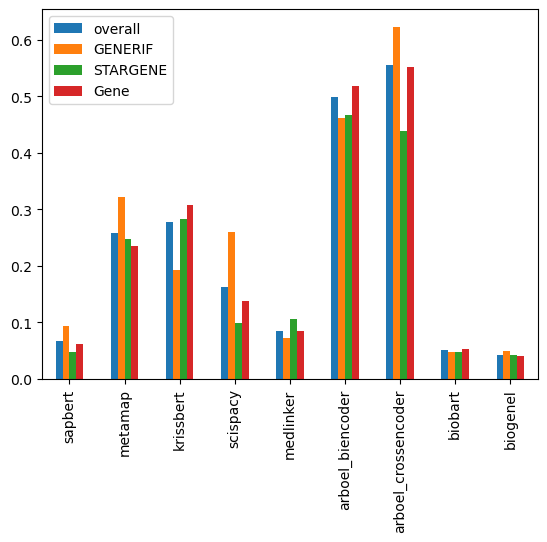

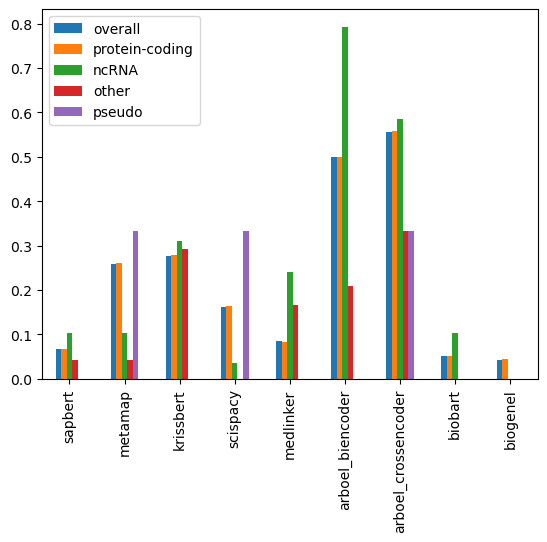

In [163]:
# match_df = convert_df_to_match_at_k(df, usable_model_cols)
name = 'nlm_gene'
match_df = all_match_dfs[name]
for type_col in ['type','ontology_types','taxonomy']:
    if type_col == 'taxonomy' and name not in ['gnormplus','nlmgene']:
        continue
    summary_dict = generate_type_output_summary(match_df, models, type_col, resolve_abbrevs=False)
    pd.DataFrame(summary_dict).T.plot.bar()
    plt.savefig(f'../figures/{name}_{type_col}_analysis_bar_plot.png')

,SapBERT,MetaMap,KRISSBERT,SciSpacy,MedLinker,ClusterEL,ArboEL,BioBART,BioGenEL
Overall,0.636724,0.568119,0.559325,0.572404,0.520963,0.692101,0.746730,0.495678,0.520390
No alias match,0.584538,0.514289,0.538168,0.516919,0.490439,0.653900,0.710642,0.483760,0.490469
Wrong match,0.378038,0.354660,0.430637,0.397109,0.356813,0.535835,0.596432,0.339895,0.307290
<5 aliases,0.562573,0.483390,0.504201,0.487174,0.501308,0.652273,0.696010,0.439319,0.441155
Zero-shot,0.586154,0.488149,0.000000,0.534671,0.222467,0.492007,0.589792,0.367435,0.461360


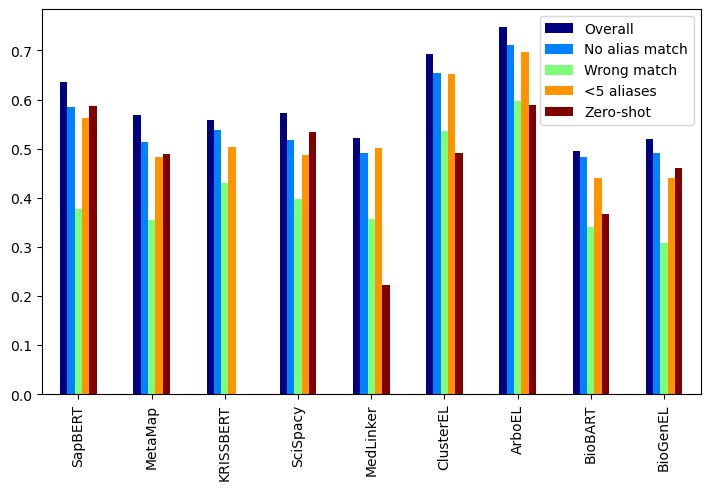

In [35]:


# match_df = convert_df_to_match_at_k(df, usable_model_cols)
name='medmentions_st21pv'
match_df = all_match_dfs[name]
filter_cols_subset = ['no_alias_match', 'wrong_alias_match', 'five_alias_or_less', 'zero_shot']
subset_to_pretty_name = {'no_alias_match':"No alias match", 'wrong_alias_match':'Wrong match', 'five_alias_or_less':'<5 aliases', 'zero_shot':'Zero-shot'}
summary_dict = generate_model_summary_report(match_df, models, filter_cols_subset, resolve_abbrevs=True)
# summary_dict
plot_df = pd.DataFrame(summary_dict)
plot_df.columns = plot_df.columns.map(model_to_pretty_name)
plot_df.index = plot_df.index.map(lambda x: subset_to_pretty_name[x] if x in subset_to_pretty_name else x.title())
display(plot_df)
fig, ax = plt.subplots(1,1, sharex=True, sharey=True, figsize=(8.5,5))
plot_df.T.plot.bar(ax=ax, cmap='jet')
plt.savefig(f'../figures/{name}_error_analysis_bar_plot.png', bbox_inches='tight', transparent="True", pad_inches=0)

# Effect of abbreviation resolution

In [1]:
abbrev_stats = analyze_abbreviation_resolution(match_df, models)
abbrev_df = pd.DataFrame(abbrev_stats).round(3)
abbrev_df['dataset'] = name
abbrev_df



NameError: name 'analyze_abbreviation_resolution' is not defined

In [16]:
df

,document_id,text,deabbreviated_text,type,db_ids,mention_id,joined_offsets,arboel_biencoder,arboel_biencoder_resolve_abbrev,arboel_crossencoder,...,scispacy,scispacy_resolve_abbrev,is_abbrev,has_alias_match,no_alias_match,wrong_alias_match,train_match,train_entity_match,perfect_train_match,ontology_types
0,9288106,ataxia-telangiectasia,ataxia-telangiectasia,[Modifier],[MESH:D001260],9288106.1,"40,61",0,0,0,...,0,1000000,False,False,True,False,True,True,True,"[a, e, s, D, i]"
1,9288106,sporadic T-cell leukaemia,sporadic T-cell leukaemia,[SpecificDisease],[MESH:D015458],9288106.2,"72,97",0,0,0,...,19,1000000,False,False,True,False,False,False,False,"[a, e, s, D, i]"
2,9288106,Ataxia-telangiectasia,Ataxia-telangiectasia,[SpecificDisease],[MESH:D001260],9288106.3,"99,120",0,0,0,...,0,1000000,False,False,True,False,True,True,True,"[a, e, s, D, i]"
3,9288106,A-T,Ataxia-telangiectasia,[SpecificDisease],[MESH:D001260],9288106.4,"122,125",0,0,0,...,1000000,1000000,True,False,True,False,True,True,True,"[a, e, s, D, i]"
4,9288106,recessive multi-system disorder,recessive multi-system disorder,[DiseaseClass],[MESH:D030342],9288106.5,"132,163",1,1,0,...,1000000,1000000,False,False,True,False,False,True,False,"[a, e, s, D, i]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
955,9988281,breast malignancies,breast malignancies,[SpecificDisease],[MESH:D001943],9988281.7,"996,1015",0,0,0,...,4,1000000,False,False,True,False,False,True,False,"[a, e, s, D, i]"
956,9988281,invasive lobular cancers,invasive lobular cancers,[DiseaseClass],[MESH:D018275],9988281.8,"1123,1147",4,4,0,...,1000000,1000000,False,False,True,False,False,False,False,"[a, e, s, D, i]"
957,9988281,low-grade ductal carcinomas,low-grade ductal carcinomas,[SpecificDisease],[MESH:D044584],9988281.9,"1152,1179",1,1,1,...,2,1000000,False,False,True,False,False,False,False,"[a, e, s, D, i]"
958,9988281,ductal carcinomas,ductal carcinomas,[SpecificDisease],[MESH:D044584],9988281.10,"1269,1286",0,0,0,...,0,1000000,False,False,True,False,False,False,False,"[a, e, s, D, i]"
